In [1]:
import math
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torchvision.utils import save_image

from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device} {torch.cuda.get_device_name(0)}")

c:\Users\detac\miniconda3\envs\pytorch_2_1_0_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
def linear_beta_scheduler(timesteps, initial_beta=0.0001, final_beta=0.02):
    return torch.linspace(initial_beta, final_beta, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

# Define beta scheduler
T = 500
betas = linear_beta_scheduler(timesteps=T)

# Define terms for the closed form
alphas = 1.0 - betas  # reparametrization
alphas_cumprod = torch.cumprod(alphas, dim=0)  # cumulative product of alphas
alphas_cumprod_prev = torch.cat((torch.tensor([1.0]), alphas_cumprod[:-1]))  # cumulative product of alphas shifted by 1
# Terms for forward diffusion and reverse denoising
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)  # square root of (cumulative product of alphas)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)  # square root of (1 - cumulative product of alphas)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)  # square root of reciprocal alphas
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)  # variance of the posterior

In [3]:
def get_vals_from_list(vals, t, x_shape):
    """
    Returns a index t from a list of values vals while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    out = out.reshape(batch_size, *((1,) * (len(x_shape) -1)))
    
    return out.to(device)

def forward_diffusion(x_0, t, noise=None):
    """
    Takes a batch of initial states x_0 and a batch of time indices t and returns the corresponding forward process.
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_vals_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_vals_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    # Forward diffusion formula (mean + variance)
    x_t = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    x_t = x_t.clamp(-1.0, 1.0)
    
    return x_t

In [4]:
# Load the dataset
IMG_SIZE = 32
BATCH_SIZE = 32

def load_transformed_dataset():
    data_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(), # Normalize to [0, 1]
            transforms.Lambda(lambda x: (x * 2.0) - 1.0), # Scale to [-1, 1]
        ]
    )
    dataset_transformed = torchvision.datasets.MNIST(root='data/', transform=data_transform, download=True)
    eight_indices = [i for i, (_, label) in enumerate(dataset_transformed) if label == 8]
    eight_dataset_transformed = Subset(dataset_transformed, eight_indices)
    
    return eight_dataset_transformed
    
transformed_dataset = load_transformed_dataset()
data_loader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
# Show images from the transformed dataloader
def show_tensor_image(image):
    reverse_transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x.cpu()),
            transforms.Lambda(lambda x: x.clamp(-1, 1)),
            transforms.Lambda(lambda x: (x + 1.0) / 2.0), # Scale to [0, 1]
            transforms.Lambda(lambda x: x.permute(1, 2, 0)), # C,H,W -> H,W,C
            transforms.Lambda(lambda x: x * 255.0), # Scale to [0, 255]
            transforms.Lambda(lambda x: x.numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ]
    )
    # Show image of the first batch element
    if len(image.shape) == 4:
        image = image[0]
    plt.imshow(reverse_transform(image), cmap='gray')

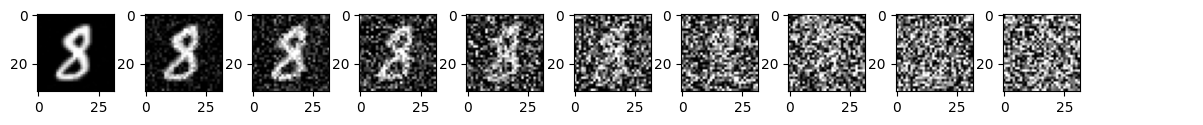

In [6]:
# Forward process simulation
test_batch = next(iter(data_loader))[0]

plt.figure(figsize=(15, 1))
plt.axis('off')
num_images = 10
step_size = T // num_images

for idx in range(0, T, step_size):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, idx//step_size+1)
    test_x_t = forward_diffusion(test_batch, t)
    show_tensor_image(test_x_t)

In [ ]:
# Deep-Res-UNet 
# https://arxiv.org/pdf/1711.10684.pdf

class BatchNormReLU(nn.Module):
    def __init__(self, in_channels) -> None:
        super().__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.activation = nn.ReLU()
    
    def forward(self, x) -> torch.Tensor:
        out = self.norm(x)
        out = self.activation(out)
        return out
    

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.1) -> None:
        super().__init__()
        
        """ Convolutional Layers """
        self.br1 = BatchNormReLU(in_channels)
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.br2 = BatchNormReLU(out_channels)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        """ Identity Mapping """
        self.c3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0)
        
        """ Dropout """
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout2d(p=dropout_rate)
    
    def forward(self, x) -> torch.Tensor:
        out = self.br1(x)
        out = self.c1(out)
        out = self.br2(out)
        out = self.c2(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        out = out + self.c3(x)
        return out
    
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.1) -> None:
        super().__init__()
        
        """Up sampling"""
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        
        """ Convolutional Layers """
        self.br1 = BatchNormReLU(in_channels)
        self.c1 = nn.Conv2d(in_channels//2 + out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.br2 = BatchNormReLU(out_channels)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        """ Identity Mapping """
        self.c3 = nn.Conv2d(in_channels//2 + out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        
        """ Dropout """
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout2d(p=dropout_rate)
    
    def forward(self, x, skip) -> torch.Tensor:
        out = self.up(x)
        # align the dimensions of the skip connection and the upsampled x
        diffY = out.shape[2] - skip.shape[2]
        diffX = out.shape[3] - skip.shape[3]
        skip = F.pad(skip, (0, diffX, 0, diffY), mode='reflect')
        # concatenate the skip connection with the upsampled x
        out = identity = torch.cat([out, skip], 1)
        out = self.br1(out)
        out = self.c1(out)
        out = self.br2(out)
        out = self.c2(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        out = out + self.c3(identity)
        return out
            

class ResUNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        """ Encoder 1 """
        self.c11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.br1 = BatchNormReLU(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.c13 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0)  # identity mapping
        
        """ Encoder 2 & 3 """
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        
        """ Bridge """
        self.e4 = EncoderBlock(256, 512)
        
        """ Decoder 1 & 2 & 3"""
        self.d1 = DecoderBlock(512, 256)
        self.d2 = DecoderBlock(256, 128)
        self.d3 = DecoderBlock(128, 64)
        
        """ Output """
        self.out_conv = nn.Conv2d(64, 3, kernel_size=1, stride=1, padding=0)
        self.out_activation = nn.Tanh()
    
    def forward(self, x) -> torch.Tensor:
        """ Encoder 1 """
        out = self.c11(x)
        out = self.br1(out)
        out = self.c12(out)
        out = c1 = out + self.c13(x)
        
        """ Encoder 2 & 3 """
        out = c2 = self.e2(out)
        out = c3 = self.e3(out)
        
        """ Bridge """
        out = self.e4(out)
        
        """ Decoder 1 & 2 & 3 """
        out = self.d1(out, c3)
        out = self.d2(out, c2)
        out = self.d3(out, c1)
        
        """ Output """
        out = self.out_conv(out)
        out = self.out_activation(out)
        
        return out
        

In [7]:
# Denoising Diffusion Probabilistic Model (DDPM)
# https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=5ed0757b

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta=10000) -> None:
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, time) -> torch.Tensor:
        device = time.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# building block modules

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.act = nn.GELU()
    
    def forward(self, x, scale_shift=None) -> torch.Tensor:
        out = self.conv(x)
        out = self.norm(out)
        
        """ time embedding (scale and shift) """
        if scale_shift is not None:
            scale, shift = scale_shift
            out = out * (scale + 1) + shift
        
        out = self.act(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim = None, groups=8) -> None:
        super().__init__()
        
        """ time embedding projection """
        self.mlp = nn.Sequential(
            nn.GELU(),
            nn.Linear(time_emb_dim, out_channels * 2),
        ) if time_emb_dim is not None else None
        
        """ convolutional layers """
        self.block1 = BasicBlock(in_channels, out_channels, groups=groups)
        self.block2 = BasicBlock(out_channels, out_channels, groups=groups)
        
        """ identity mapping """
        self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, time_emb=None) -> torch.Tensor:
        """ time embedding projection """
        scale_shift = None
        if time_emb is not None and self.mlp is not None:
            time_emb = self.mlp(time_emb) # [B, C * 2]
            time_emb = time_emb.view(time_emb.shape[0], time_emb.shape[1], 1, 1)  # [B, C] -> [B, C, 1, 1]
            scale_shift = time_emb.chunk(2, dim=1)  # split into scale and shift: [B, C, 1, 1] -> [B, C//2, 1, 1], [B, C//2, 1, 1]
        
        """ forward pass """
        out = self.block1(x, scale_shift)
        out = self.block2(out)
        out = out + self.res(x)
        return out

class FullAttention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32) -> None:
        super().__init__()
        # scaling factor for the dot product (from the original Transformer paper)
        self.scale = dim_head ** -0.5
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.to_qkv = nn.Conv2d(dim, 3 * (dim_head * num_heads), kernel_size=1, bias=False)
        self.to_out = nn.Conv2d(dim_head * num_heads, dim, 1)
        
    def forward(self, x) -> torch.Tensor:
        b, c, h, w = x.shape
        qkv = self.to_qkv(x) # [B, 3 * (dim_head * num_heads), H, W]
        qkv = qkv.view(b, 3, self.num_heads, self.dim_head, h * w) # [B, 3, num_heads, dim_head, H * W]
        q, k, v = qkv.unbind(dim=1) # [B, num_heads, dim_head, H * W]
        
        # compute the attention map
        attn = (k.transpose(-2, -1) @ q) * self.scale # [B, num_heads, H * W, H * W]
        
        # apply softmax to the attention map
        attn = attn.softmax(dim=-2)
        
        # apply the attention map to the value
        out = v @ attn # [B, num_heads, dim_head, H * W]
        out = out.view(b, self.dim_head * self.num_heads, h, w) # [B, dim_head * num_heads, H, W]
        
        # project the output
        out = self.to_out(out) # [B, C, H, W]
        
        return out

class LinearAttention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32) -> None:
        super().__init__()
        # scaling factor for the dot product (from the original Transformer paper)
        self.scale = dim_head ** -0.5
        self.num_heads = num_heads
        self.dim_head = dim_head
        hidden_dim = dim_head * num_heads
        self.to_qkv = nn.Conv2d(dim, 3 * hidden_dim, kernel_size=1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))
        
    def forward(self, x) -> torch.Tensor:
        b, c, h, w = x.shape
        qkv = self.to_qkv(x) # [B, 3 * hidden_dim, H, W]
        qkv = qkv.view(b, 3, self.num_heads, self.dim_head, h * w) # [B, 3, num_heads, dim_head, H * W]
        q, k, v = qkv.unbind(dim=1) # [B, num_heads, dim_head, H * W]
        
        # apply softmax to the q and k
        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)
        
        # apply the scaling factor
        q = q * self.scale
        
        # linear attention
        context = v @ k.transpose(-2, -1) # [B, num_heads, dim_head, dim_head]
        out = context @ q # [B, num_heads, dim_head, H * W]
        
        # reshape the output
        out = out.view(b, self.num_heads * self.dim_head, h, w) # [B, hidden_dim, H, W]
        
        out = self.to_out(out) # [B, C, H, W]
        return out

# Model

class UNet(nn.Module):
    def __init__(
        self,
        init_dim=64,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        layer_attn_heads=4,
        layer_attn_dim_head=32,
        linear_attn=True,
    ):
        super().__init__()
        
        """ determine the dimensions """        
        self.init_conv = nn.Conv2d(channels, init_dim, kernel_size=7, padding=3)
        
        dims = [init_dim] + [init_dim * m for m in dim_mults]  # dimensions of the blocks [64, 64, 128, 256, 512]
        dims_in_out = list(zip(dims[:-1], dims[1:])) # dimension pairs of the blocks input and output [(64, 64), (64, 128), (128, 256), (256, 512)]
        
        block = partial(ResidualBlock, groups=resnet_block_groups)
        attn_layer = partial(LinearAttention) if linear_attn else partial(FullAttention)
        
        """ time embedding """
        if with_time_emb:
            time_emb_dim = init_dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPosEmb(init_dim),
                nn.Linear(init_dim, time_emb_dim),
                nn.GELU(),
                nn.Linear(time_emb_dim, time_emb_dim),
            )
        else:
            time_emb_dim = None
            self.time_mlp = None
        
        """ layers """
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(dims_in_out)
        
        # downsampling blocks
        for idx, (dim_in, dim_out) in enumerate(dims_in_out): # [(64, 64), (64, 128), (128, 256), (256, 512)]
            is_last = (idx >= num_resolutions - 1)
            self.downs.append(
                nn.ModuleList(
                    [
                        block(dim_in, dim_out, time_emb_dim=time_emb_dim),
                        block(dim_out, dim_out, time_emb_dim=time_emb_dim),
                        attn_layer(dim_out, num_heads=layer_attn_heads, dim_head=layer_attn_dim_head),
                        nn.Conv2d(dim_out, dim_out, kernel_size=4, stride=2, padding=1) if not is_last else nn.Identity(),
                    ]
                )
            )
        
        # bottleneck blocks
        mid_dim = dims[-1]
        self.mid_block_1 = block(mid_dim, mid_dim, time_emb_dim=time_emb_dim)
        self.mid_attn = attn_layer(mid_dim, num_heads=layer_attn_heads, dim_head=layer_attn_dim_head)
        self.mid_block_2 = block(mid_dim, mid_dim, time_emb_dim=time_emb_dim)
        
        # upsampling blocks
        for idx, (dim_in, dim_out) in enumerate(reversed(dims_in_out)): # [(256, 512), (128, 256), (64, 128), (64, 64)]
            is_last = (idx >= num_resolutions - 1)
            self.ups.append(
                nn.ModuleList(
                    [
                        block(dim_out * 2, dim_in, time_emb_dim=time_emb_dim), # dim_out * 2 because of the skip connection
                        block(dim_in, dim_in, time_emb_dim=time_emb_dim),
                        attn_layer(dim_in, num_heads=layer_attn_heads, dim_head=layer_attn_dim_head),
                        nn.ConvTranspose2d(dim_in, dim_in, kernel_size=4, stride=2, padding=1) if not is_last else nn.Identity(),
                    ]
                )
            )
        
        # final convolution
        out_dim = out_dim if out_dim is not None else channels
        self.final_conv = nn.Sequential(
            block(init_dim, init_dim),
            nn.Conv2d(init_dim, out_dim, kernel_size=1, padding=0),
        )
    
    def forward(self, x, time=None) -> torch.Tensor:
        """ initial convolution & time embedding """
        x = self.init_conv(x)
        t = self.time_mlp(time) if self.time_mlp is not None else None
        h = [] # skip connections
        
        """ downsampling """
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        
        """ bottleneck """
        x = self.mid_block_1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block_2(x, t)
        
        """ upsampling """
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)
        
        """ final convolution """
        x = self.final_conv(x)
        
        return x
        

In [11]:
""" Training Loss """
def p_losses(denoise_model, x_0, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_0).to(device)

    x_noisy = forward_diffusion(x_0=x_0, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

""" Sampling """
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = get_vals_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_vals_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_vals_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean.clamp(-1.0, 1.0)
    else:
        posterior_variance_t = get_vals_from_list(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return (model_mean + torch.sqrt(posterior_variance_t) * noise).clamp(-1.0, 1.0)

""" Sampling with Saving Images """
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    batch_size = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    # Denoise the images from t = T to t = 0
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        img = p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=8, channels=3):
    shape = (batch_size, channels, image_size, image_size)
    return p_sample_loop(model, shape)

In [27]:
model = UNet(channels=1) # channels=1 for MNIST
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
def train(model, data_loader, optimizer, epochs=10):
    for epoch in range(epochs):
        for step, (batch, label) in enumerate(data_loader):
            optimizer.zero_grad()
            
            batch_size = batch.shape[0]
            batch = batch.to(device)
            
            # Sample random time steps
            t = torch.randint(0, T, (batch_size,), device=device).long()
            
            # Calculate the loss
            loss = p_losses(model, batch, t, loss_type="huber")
            
            # Print loss
            if step % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Step [{step}/{len(data_loader)}] Loss: {loss.item()}")
            
            # Backpropagation
            loss.backward()
            optimizer.step()

In [30]:
train(model, data_loader, optimizer, epochs=15)

Epoch [1/15] Step [0/182] Loss: 0.42904454469680786
Epoch [1/15] Step [100/182] Loss: 0.424252986907959
Epoch [2/15] Step [0/182] Loss: 0.4179588556289673
Epoch [2/15] Step [100/182] Loss: 0.42386510968208313
Epoch [3/15] Step [0/182] Loss: 0.4200454652309418
Epoch [3/15] Step [100/182] Loss: 0.08870634436607361
Epoch [4/15] Step [0/182] Loss: 0.07630091905593872
Epoch [4/15] Step [100/182] Loss: 0.06756320595741272
Epoch [5/15] Step [0/182] Loss: 0.07426770031452179
Epoch [5/15] Step [100/182] Loss: 0.06691651791334152
Epoch [6/15] Step [0/182] Loss: 0.07074959576129913
Epoch [6/15] Step [100/182] Loss: 0.07710817456245422
Epoch [7/15] Step [0/182] Loss: 0.06003537029027939
Epoch [7/15] Step [100/182] Loss: 0.06873166561126709
Epoch [8/15] Step [0/182] Loss: 0.07302003353834152
Epoch [8/15] Step [100/182] Loss: 0.060631126165390015
Epoch [9/15] Step [0/182] Loss: 0.06218431144952774
Epoch [9/15] Step [100/182] Loss: 0.06720574200153351
Epoch [10/15] Step [0/182] Loss: 0.06312975287437

sampling loop time step: 100%|██████████| 500/500 [00:11<00:00, 44.90it/s]


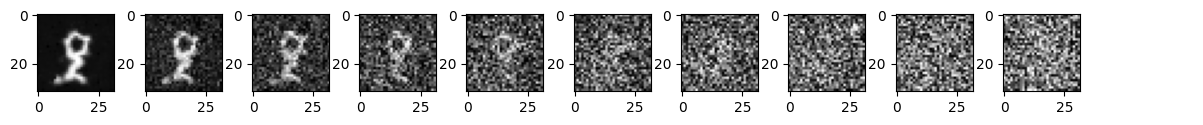

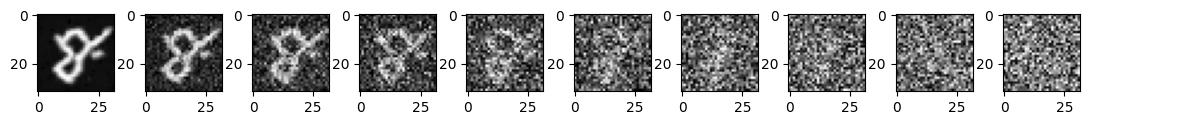

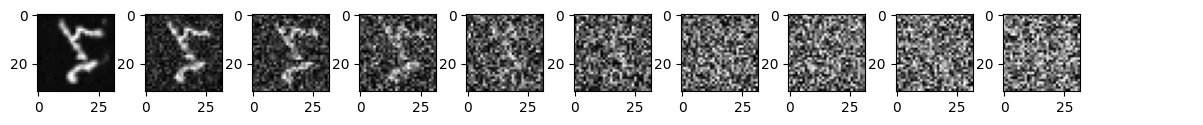

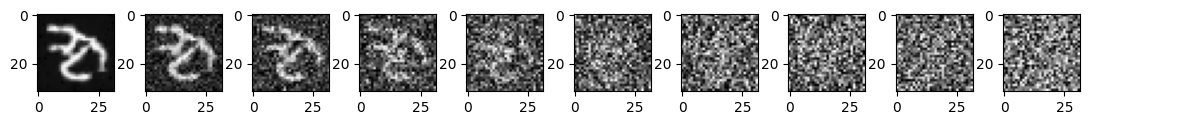

In [37]:
random_sample_number = 4
samples = sample(model, image_size=IMG_SIZE, batch_size=random_sample_number, channels=1)

for sample_idx in range(random_sample_number):
    plt.figure(figsize=(15, 1))
    plt.axis('off')
    num_images = 10
    step_size = T // num_images
    for idx in range(0, T, step_size):
        t = torch.Tensor([idx]).type(torch.int64)
        plt.subplot(1, num_images + 1, idx//step_size+1)
        show_tensor_image(samples[T-idx-1][sample_idx])